# Image classification with CNN

## Do the necessary imports and library setting

> If you are wondering whether to use keras or tf.keras, here is good read - https://pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/. But I am using keras independently as auto complete is not working on tf.keras. Issue link - https://github.com/tensorflow/tensorflow/issues/56231

In [2]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Datasets from Google

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

## Listing datasets

In [4]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/Users/anupmanekar/.keras/datasets
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/train
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/train/dogs
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/train/cats
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/validation
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/Users/anupmanekar/.keras/datasets/cats_and_dogs_filtered/validation/cats


## Assigning Training and Validation datasets
### Since the data is divided into training and validation datasets which is further divided into cats and dogs directory, we can use it dataset creation directly using FileIO operations.

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Get Dataset statistics
### We will fetch the counts of each datasets so as to divide them correctly for training and then validation

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Data Preprocessing

#### Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values. This is **Normalization** process

> **Normalization** will help our algorithm to train better. The reason we typically want normalized pixel values is because neural networks rely on gradient calculations. These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing the pixel values helps these gradient calculations stay consistent, and not get so large that they slow down or prevent a network from training.

In [7]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

## Data Augmentation

#### To avoid overfitting, we need to add more training data. This can be achieved by what is called as data/image augmentation. Basically, scramble data or resize/rotate/zoom image data and feed it. To do all the scrambling activities on images, we define a new image generator.

In [8]:
image_augmentor_train = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

#### All the steps from 1 to 4 are done using flow_from_directory method of ImageDataGenerator. 

In [9]:
train_data_gen = image_augmentor_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Visualizing one sample image

We first get batch of sample images using **next** function and then plot few of them on plotlib

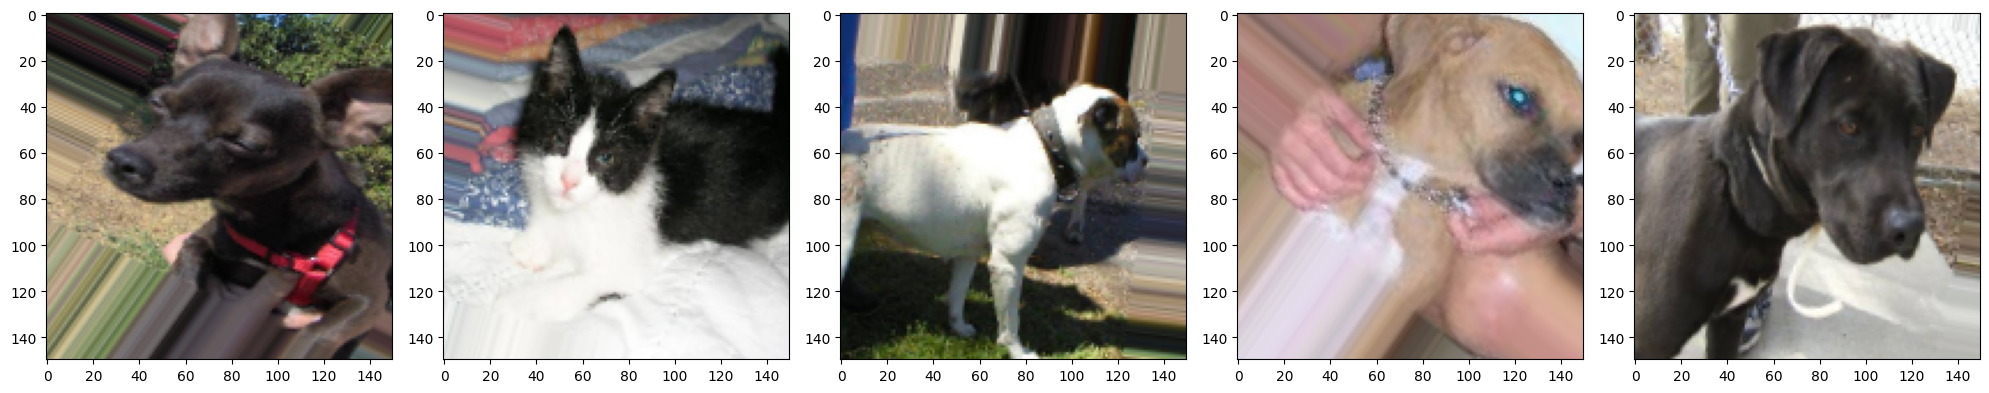

In [15]:
sample_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_images[:5])  # Plot images 0-4

## Define Model

#### Sequential model with 11 Layers
1. 4 Convolution Layers with Max Pool Layer linked - 8 Layers
2. 1 Flattening Layer
3. 1 Dropout layer to drop 50% of values coming into this layer for making this more resilient
4. 2 Dense Networks Layer with 512 units and "relu" activation method

Please note that last layer has two output units. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

## Compile Model

#### Please note following:
1. We will use the adam optimizer. 
2. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. 
3. We track training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [17]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model(Setup) Summary

In [ ]:
model.summary()

## Train Model

#### We will be using fit_generator method as the data is coming in batches from ImageDataGenerator

In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

## Visualize Training Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()